<a href="https://colab.research.google.com/github/agigibairene/Translator/blob/main/Translation_model_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import json

In [ ]:
# File paths (assuming they're in the same directory as your notebook)
files = [
    "/content/kinyarwanda-english-corpus.tsv",
    "/content/kinyarwanda-english-corpus2.tsv",
    "/content/kinyarwanda-english-corpus3.tsv"
]

# Load datasets
datasets = [pd.read_csv(file, sep="\t", encoding="ISO-8859-1") for file in files]

In [ ]:
# Inspect structure of each dataset
for i, df in enumerate(datasets, 1):
    print(f"Dataset {i} shape: {df.shape}")
    print(df.head(), "\n")

Dataset 1 shape: (14410, 2)
                    Uruvunge rwabatuye uwo mujyi   \
0                       amuhamagara kuri telefone    
1                      Pawulo yakundaga Timoteyo    
2                      cyangwa ngo imenye aho ijya   
3                  Ngendahimana yashakaga ikaramu    
4  che guevara yahuye numunyacubahiro raul castro   

  The crowd of the people who live in that city  
0                   he called him on the phone   
1                          Paul loved Timothy   
2                or that it knows where it goes  
3            Ngendahimana was looking for a pen  
4    che guevara with his honorable raul castro   

Dataset 2 shape: (25014, 2)
  Ababyeyi babo bamaze gupfa basogokuru barabareze.   \
0  Waba uzi umubare wabantu bitabiriye kubyina ic...   
1    Jya kuryama Ugomba kubyuka kare ejo mugitondo.    
2    Nzasimbuza igihe cyatakaye nkora uko nshoboye.    
3  Ngomba kumanika nonaha. Umuntu ategereje gukor...   
4  Niba imiti idakora birashoboka ko 

In [ ]:
# Standardize column names
for i, df in enumerate(datasets):
    df.columns = ["kinyarwanda", "english"]
    print(f"Dataset {i+1} column names: {df.columns}")

# Merge all datasets
combined_df = pd.concat(datasets, ignore_index=True)

# Check final dataset shape and first few rows
print("Final dataset shape:", combined_df.shape)
print(combined_df.head())

Dataset 1 column names: Index(['kinyarwanda', 'english'], dtype='object')
Dataset 2 column names: Index(['kinyarwanda', 'english'], dtype='object')
Dataset 3 column names: Index(['kinyarwanda', 'english'], dtype='object')
Final dataset shape: (47821, 2)
                                       kinyarwanda  \
0                       amuhamagara kuri telefone    
1                      Pawulo yakundaga Timoteyo    
2                      cyangwa ngo imenye aho ijya   
3                  Ngendahimana yashakaga ikaramu    
4  che guevara yahuye numunyacubahiro raul castro   

                                      english  
0                 he called him on the phone   
1                        Paul loved Timothy   
2              or that it knows where it goes  
3          Ngendahimana was looking for a pen  
4  che guevara with his honorable raul castro  


In [ ]:
# Check for missing values
print("Missing values:\n", combined_df.isnull().sum())

Missing values:
 kinyarwanda     8
english        12
dtype: int64


In [ ]:
# Check for duplicates
print("\nDuplicate rows:", combined_df.duplicated().sum())


Duplicate rows: 2376


In [ ]:
# Inspect a few random samples for unusual characters
print("\nRandom samples:")
print(combined_df.sample(5))


Random samples:
                                             kinyarwanda  \
46406  Umusaza wambaye ishati yubururu yitwaje ikintu...   
8994                     Amaze kubona ibi, arahaguruka     
29837       Ikipe yacu yatsinze mumarushanwa ya kaminuza   
44439  Abantu babiri barimo kwikuramo umugozi mumazi ...   
3727   indirimbo yigihugu ni indirimbo umuntu wese ag...   

                                                 english  
46406  An old man wearing a blue shirt carried someth...  
8994                         When he saw this, he got up  
29837            Our team won the university competition  
44439    Two people are pulling a rope out of blue water  
3727   a national anthem is a song that should be kno...  


In [ ]:
# Drop missing values
combined_df = combined_df.dropna()

# Drop duplicate rows
combined_df = combined_df.drop_duplicates()

# Reset index
combined_df = combined_df.reset_index(drop=True)

# Check final shape
print("Final dataset shape:", combined_df.shape)

Final dataset shape: (45441, 2)


In [ ]:
# Display unique characters in the dataset
unique_chars = set("".join(combined_df["kinyarwanda"].astype(str)) + "".join(combined_df["english"].astype(str)))
print("Unique characters in dataset:\n", sorted(unique_chars))

Unique characters in dataset:
 [' ', '!', '"', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x85', '\x91', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '«', '´', '»', 'Â', 'ã', 'æ', 'é', 'í', 'ô']


In [ ]:
def clean_text(text):
    text = text.replace("\xa0", " ")  # Non-breaking space
    text = text.replace("Â", "").replace("ã", "a").replace("æ", "ae")  # Common encoding artifacts
    text = re.sub(r"[\x85\x91-\x97]", "", text)  # Remove unwanted byte characters
    text = text.strip()  # Remove extra spaces
    return text

# Apply cleaning to both columns
combined_df["kinyarwanda"] = combined_df["kinyarwanda"].apply(clean_text)
combined_df["english"] = combined_df["english"].apply(clean_text)

# Verify cleanup
print("Sample cleaned rows:\n", combined_df.sample(5))

Sample cleaned rows:
                                              kinyarwanda  \
2108                   Nzagomba gukuraho iyi tapi ishaje   
36222                            Hariho akazi ko gukora.   
22498                          mbona bamwe bari gutitira   
12578                                     Ibi abikura he   
40641  Abadamu babiri kumeza hamwe nigitambara gituku...   

                                                 english  
2108               I will have to remove this old carpet  
36222                          There is work to be done.  
22498                           I saw some of them shake  
12578                        Where do you get this from?  
40641  Two ladies at the table and a red dress playin...  


In [ ]:
pip install nltk


In [ ]:
# Download NLTK resources (if not already downloaded)
nltk.download('punkt')

# Function to preprocess and tokenize (space-based tokenization for Kinyarwanda)
def preprocess_and_tokenize(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove unwanted characters
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    # Tokenize by splitting on spaces
    tokens = text.split()
    return tokens

# Apply preprocessing to both columns
combined_df["kinyarwanda_tokens"] = combined_df["kinyarwanda"].apply(preprocess_and_tokenize)
combined_df["english_tokens"] = combined_df["english"].apply(preprocess_and_tokenize)

# Display sample of tokenized data
print("Sample tokenized rows:\n", combined_df[['kinyarwanda_tokens', 'english_tokens']].sample(5))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Sample tokenized rows:
                                       kinyarwanda_tokens  \
23408                     [kuki, utafata, umwanya, muto]   
37617  [umugore, wishimira, gusoma, mu, iduka, rya, k...   
1082                           [byabereye, byose, rimwe]   
1717                 [ntiwibagirwe, gufunga, iyo, ugiye]   
40983  [itsinda, ryabasore, bashyinguwe, mu, gituza, ...   

                                          english_tokens  
23408                  [why, not, take, a, little, time]  
37617  [a, woman, who, enjoys, reading, in, a, coffee...  
1082                [it, all, happened, the, same, time]  
1717           [dont, forget, to, close, where, you, go]  
40983  [a, group, of, young, men, are, buried, in, th...  


In [ ]:
# Create tokenizer for Kinyarwanda
kinyarwanda_tokenizer = Tokenizer()
kinyarwanda_tokenizer.fit_on_texts(combined_df["kinyarwanda"])

# Create tokenizer for English
english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(combined_df["english"])

# Get the word index (vocabulary)
kinyarwanda_vocab = kinyarwanda_tokenizer.word_index
english_vocab = english_tokenizer.word_index

# Define a fixed sequence length
sequence_length = 60

# Pad or truncate sequences for both Kinyarwanda and English tokens
kinyarwanda_padded = pad_sequences(
    combined_df["kinyarwanda_tokens"].apply(lambda x: [kinyarwanda_vocab.get(w, 0) for w in x]),
    maxlen=sequence_length, padding='post', truncating='post')

english_padded = pad_sequences(
    combined_df["english_tokens"].apply(lambda x: [english_vocab.get(w, 0) for w in x]),
    maxlen=sequence_length, padding='post', truncating='post')

# Check the shape of the padded data
print("Padded Kinyarwanda data shape:", kinyarwanda_padded.shape)
print("Padded English data shape:", english_padded.shape)


Padded Kinyarwanda data shape: (45441, 60)
Padded English data shape: (45441, 60)


In [ ]:
# Split the data into training and validation sets (80% for training, 20% for validation)
kinyarwanda_train, kinyarwanda_val, english_train, english_val = train_test_split(
    kinyarwanda_padded, english_padded, test_size=0.2, random_state=42)

# Check the shapes of the training and validation sets
print("Training Kinyarwanda shape:", kinyarwanda_train.shape)
print("Validation Kinyarwanda shape:", kinyarwanda_val.shape)
print("Training English shape:", english_train.shape)
print("Validation English shape:", english_val.shape)

Training Kinyarwanda shape: (36352, 60)
Validation Kinyarwanda shape: (9089, 60)
Training English shape: (36352, 60)
Validation English shape: (9089, 60)


In [ ]:
# Define the train size (e.g., 80% for training, 20% for validation)
train_size = int(0.8 * len(kinyarwanda_padded))

# Padded data for training and validation
train_kinyarwanda, val_kinyarwanda = kinyarwanda_padded[:train_size], kinyarwanda_padded[train_size:]
train_english, val_english = english_padded[:train_size], english_padded[train_size:]

# Define the vocab size for Kinyarwanda and English
kinyarwanda_vocab_size = len(kinyarwanda_tokenizer.word_index) + 1
english_vocab_size = len(english_tokenizer.word_index) + 1

In [ ]:
def transformer_model(input_vocab_size, target_vocab_size, seq_length, d_model=64, num_heads=4, num_layers=2):
    # Encoder Input
    encoder_input = Input(shape=(seq_length,))
    encoder_embedding = Embedding(input_vocab_size, d_model)(encoder_input)

    # Add Positional Encoding
    position_encoding = get_positional_encoding(seq_length, d_model)
    encoder_input_with_pos = encoder_embedding + position_encoding

    # Encoder Layers
    encoder_output = encoder_input_with_pos
    for _ in range(num_layers):
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(encoder_output, encoder_output)
        attention_output = Dropout(0.1)(attention_output)
        encoder_output = LayerNormalization()(encoder_output + attention_output)
        feed_forward = Dense(d_model, activation="relu")(encoder_output)
        encoder_output = LayerNormalization()(encoder_output + feed_forward)

    # Decoder Input
    decoder_input = Input(shape=(seq_length,))
    decoder_embedding = Embedding(target_vocab_size, d_model)(decoder_input)

    # Decoder Layers
    decoder_output = decoder_embedding + position_encoding
    for _ in range(num_layers):
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(decoder_output, encoder_output)
        attention_output = Dropout(0.1)(attention_output)
        decoder_output = LayerNormalization()(decoder_output + attention_output)
        feed_forward = Dense(d_model, activation="relu")(decoder_output)
        decoder_output = LayerNormalization()(decoder_output + feed_forward)

    # Output layer
    output = Dense(target_vocab_size, activation="softmax")(decoder_output)

    model = Model(inputs=[encoder_input, decoder_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def get_positional_encoding(seq_len, d_model):
    angle_rads = np.array([[pos / np.power(10000, (2 * (j // 2)) / d_model) for j in range(d_model)] for pos in range(seq_len)])
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # apply sine to even indices
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # apply cosine to odd indices
    return tf.constant(angle_rads, dtype=tf.float32)

In [ ]:
# Print tokenized samples
for i in range(5):
    print(f"Original Kinyarwanda: {combined_df.iloc[i]['kinyarwanda']}")
    print(f"Tokenized Kinyarwanda: {combined_df.iloc[i]['kinyarwanda_tokens']}")
    print(f"Original English: {combined_df.iloc[i]['english']}")
    print(f"Tokenized English: {combined_df.iloc[i]['english_tokens']}")
    print("-" * 50)

Original Kinyarwanda: amuhamagara kuri telefone
Tokenized Kinyarwanda: ['amuhamagara', 'kuri', 'telefone']
Original English: he called him on the phone
Tokenized English: ['he', 'called', 'him', 'on', 'the', 'phone']
--------------------------------------------------
Original Kinyarwanda: Pawulo yakundaga Timoteyo
Tokenized Kinyarwanda: ['pawulo', 'yakundaga', 'timoteyo']
Original English: Paul loved Timothy
Tokenized English: ['paul', 'loved', 'timothy']
--------------------------------------------------
Original Kinyarwanda: cyangwa ngo imenye aho ijya
Tokenized Kinyarwanda: ['cyangwa', 'ngo', 'imenye', 'aho', 'ijya']
Original English: or that it knows where it goes
Tokenized English: ['or', 'that', 'it', 'knows', 'where', 'it', 'goes']
--------------------------------------------------
Original Kinyarwanda: Ngendahimana yashakaga ikaramu
Tokenized Kinyarwanda: ['ngendahimana', 'yashakaga', 'ikaramu']
Original English: Ngendahimana was looking for a pen
Tokenized English: ['ngendahim

In [ ]:
# Print sample word indices
for i in range(5):
    kin_tokens = combined_df.iloc[i]["kinyarwanda_tokens"]
    eng_tokens = combined_df.iloc[i]["english_tokens"]

    kin_indices = [kinyarwanda_tokenizer.word_index.get(word, -1) for word in kin_tokens]
    eng_indices = [english_tokenizer.word_index.get(word, -1) for word in eng_tokens]

    print(f"Kinyarwanda Tokens: {kin_tokens}")
    print(f"Kinyarwanda Indices: {kin_indices}")
    print(f"English Tokens: {eng_tokens}")
    print(f"English Indices: {eng_indices}")
    print("-" * 50)


Kinyarwanda Tokens: ['amuhamagara', 'kuri', 'telefone']
Kinyarwanda Indices: [15177, 12, 1729]
English Tokens: ['he', 'called', 'him', 'on', 'the', 'phone']
English Indices: [10, 326, 40, 16, 1, 394]
--------------------------------------------------
Kinyarwanda Tokens: ['pawulo', 'yakundaga', 'timoteyo']
Kinyarwanda Indices: [161, 1538, 2959]
English Tokens: ['paul', 'loved', 'timothy']
English Indices: [239, 631, 2293]
--------------------------------------------------
Kinyarwanda Tokens: ['cyangwa', 'ngo', 'imenye', 'aho', 'ijya']
Kinyarwanda Indices: [55, 46, 10042, 70, 2192]
English Tokens: ['or', 'that', 'it', 'knows', 'where', 'it', 'goes']
English Indices: [94, 11, 12, 357, 143, 12, 549]
--------------------------------------------------
Kinyarwanda Tokens: ['ngendahimana', 'yashakaga', 'ikaramu']
Kinyarwanda Indices: [15178, 371, 2097]
English Tokens: ['ngendahimana', 'was', 'looking', 'for', 'a', 'pen']
English Indices: [7522, 22, 235, 25, 2, 1196]
---------------------------

In [ ]:
# Instantiate the model
model = transformer_model(input_vocab_size=kinyarwanda_vocab_size,
                          target_vocab_size=english_vocab_size,
                          seq_length=60)

# Train the model
history = model.fit(
    [train_kinyarwanda, train_english],
    np.expand_dims(train_english, -1),  # Target sequence (shifted by one for teacher forcing)
    epochs=10,
    batch_size=64,
    validation_data=([val_kinyarwanda, val_english], np.expand_dims(val_english, -1))
)

Epoch 1/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 1567s 3s/step - accuracy: 0.8753 - loss: 2.6593 - val_accuracy: 0.9496 - val_loss: 0.4395
Epoch 2/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 1576s 3s/step - accuracy: 0.9818 - loss: 0.1685 - val_accuracy: 0.9798 - val_loss: 0.2069
Epoch 3/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 1578s 3s/step - accuracy: 0.9926 - loss: 0.0731 - val_accuracy: 0.9854 - val_loss: 0.1472
Epoch 4/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 1594s 3s/step - accuracy: 0.9959 - loss: 0.0408 - val_accuracy: 0.9882 - val_loss: 0.1212
Epoch 5/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 1560s 3s/step - accuracy: 0.9975 - loss: 0.0252 - val_accuracy: 0.9898 - val_loss: 0.1092
Epoch 6/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 1541s 3s/step - accuracy: 0.9979 - loss: 0.0164 - val_accuracy: 0.9906 - val_loss: 0.0999
Epoch 7/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 1532s 3s/step - accuracy: 0.9994 - loss: 0.0104 - val_accuracy: 0.9924 - val_loss: 0.0967
Epoch 8/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 1502s 3s/step - accuracy: 1.0000 - loss: 0.0061 - 

In [ ]:
# Evaluate model on validation set
eval_loss, eval_accuracy = model.evaluate([val_kinyarwanda, val_english], np.expand_dims(val_english, -1))
print(f"Validation Loss: {eval_loss:.4f}")
print(f"Validation Accuracy: {eval_accuracy:.4f}")

285/285 ━━━━━━━━━━━━━━━━━━━━ 193s 677ms/step - accuracy: 0.9940 - loss: 0.0751
Validation Loss: 0.0900
Validation Accuracy: 0.9928


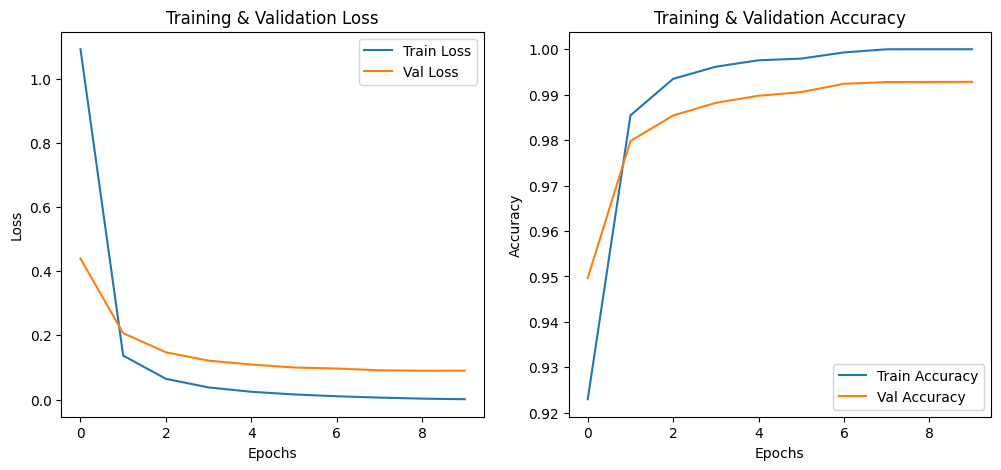

In [ ]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Translation function
def translate_text(input_text, tokenizer, max_len, model, target_tokenizer):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_seq, maxlen=max_len, padding='post')

    prediction = model.predict([input_padded, input_padded])
    predicted_seq = np.argmax(prediction, axis=-1)[0]

    translated_text = ' '.join([target_tokenizer.index_word.get(idx, '') for idx in predicted_seq if idx > 0])
    return translated_text

# Test translations
test_sentences = ["Muraho", "Ndashaka amazi", "Ese uri he?"]
for sentence in test_sentences:
    translated = translate_text(sentence, kinyarwanda_tokenizer, sequence_length, model, english_tokenizer)
    print(f"Kinyarwanda: {sentence} -> English: {translated}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Kinyarwanda: Muraho -> English: himjust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Kinyarwanda: Ndashaka amazi -> English: say others
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Kinyarwanda: Ese uri he? -> English: being three lord


In [ ]:
# Save the trained model
model.save("translation_model.h5")
model.save("trannslation_model.keras")

# Save Kinyarwanda tokenizer
kinyarwanda_tokenizer_json = kinyarwanda_tokenizer.to_json()
with open("kinyarwanda_tokenizer.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(kinyarwanda_tokenizer_json, ensure_ascii=False))

# Save English tokenizer
english_tokenizer_json = english_tokenizer.to_json()
with open("english_tokenizer.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(english_tokenizer_json, ensure_ascii=False))

print("Model and tokenizers saved successfully.")


Model and tokenizers saved successfully.
